# Year 2023 Day 18

[--- Day 18: Lavaduct Lagoon ---](https://adventofcode.com/2023/day/18)

## Motive

Using Observable Plot to visualize the Part 1 of the problem.

Note: the Part 2 is solved using the same formulas than Part 1. The difference resides in the changed input parsing method, and the scale of the problem, making it unsuited for bruteforce.

## Related puzzles

- [Notebook 202310](./notebook_problem_202310.html) (_Pipe Maze_): The goal is also to compute an area inside of a grid ; however no formula is used, only bruteforce with a flood fill algorithm. Possible, using the approach of Day 18, there would be a more efficient way to solve it.


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pyobsplot import Plot

from advent_of_code.common.common import get_example_inputs_file_contents
from advent_of_code.visualization.observable_plot import (
    ObservablePlotBuilder,
    ObservablePlotXarrayBuilder,
    create_boundary_points_layer,
    create_indicative_dots_layer,
    create_polygon_layer,
)
from advent_of_code.y_2023.problem_202318 import (
    AdventOfCodeProblem202318,
    DigInstruction,
    compute_polygon_coords,
    parse_text_input_part_1,
)

problem = AdventOfCodeProblem202318()
# input_id = "EXAMPLE_INPUT_3_X_3_LOOP"
# input_id = "EXAMPLE_INPUT_3_X_4_LOOP"
input_id = "EXAMPLE_INPUT"

In [2]:
example_input = get_example_inputs_file_contents(2023)["test_problem_202318"][input_id]
puzzle_input = parse_text_input_part_1(example_input)
dig_plan = puzzle_input
dig_plan

[DigInstruction(direction=0, meters=6, color='#70c710'),
 DigInstruction(direction=3, meters=5, color='#0dc571'),
 DigInstruction(direction=2, meters=2, color='#5713f0'),
 DigInstruction(direction=3, meters=2, color='#d2c081'),
 DigInstruction(direction=0, meters=2, color='#59c680'),
 DigInstruction(direction=3, meters=2, color='#411b91'),
 DigInstruction(direction=2, meters=5, color='#8ceee2'),
 DigInstruction(direction=1, meters=2, color='#caa173'),
 DigInstruction(direction=2, meters=1, color='#1b58a2'),
 DigInstruction(direction=1, meters=2, color='#caa171'),
 DigInstruction(direction=0, meters=2, color='#7807d2'),
 DigInstruction(direction=1, meters=3, color='#a77fa3'),
 DigInstruction(direction=2, meters=2, color='#015232'),
 DigInstruction(direction=1, meters=2, color='#7a21e3')]

## With Example Input

### Convert Problem's Input to Visualization Input

### Show the miner's path

The miner's path shapes a polygon. In the following function, the dig plan (list of dig instructions) is converted to a data structure containing the polygon coordinates using the problem's solving code. Then, this data structure is converted to a pandas DataFrame using a friendly format for the Observable Plot Link Mark.


In [3]:
def compute_links_df(
    dig_plan: list[DigInstruction],
) -> tuple[pd.DataFrame, xr.DataArray]:
    polygon_coords = compute_polygon_coords(dig_plan)

    # Note: the y, x order is important as the problems follows a row, col convention
    links_xda = xr.DataArray(
        data=polygon_coords, dims=("axis", "point"), coords={"axis": ["y", "x"]}
    )
    df = links_xda.T.to_pandas()

    df["x2"] = np.roll(df["x"], -1)
    df["y2"] = np.roll(df["y"], -1)
    df = df.rename(columns={"x": "x1"})
    df = df.rename(columns={"y": "y1"})
    df = df[["x1", "x2", "y1", "y2"]]

    links_df = pd.DataFrame(
        df[:-1]
    )  # remove redundant closing link to declutter the plot
    return links_df, links_xda


links_df, links_xda = compute_links_df(dig_plan)
print("Coordinates of the polygon's vertices:")
display(links_xda)
print("Couples of coordinates of the polygon's edges:")
display(links_df)

Coordinates of the polygon's vertices:


<xarray.DataArray (axis: 2, point: 15)>
array([[0, 0, 5, 5, 7, 7, 9, 9, 7, 7, 5, 5, 2, 2, 0],
       [0, 6, 6, 4, 4, 6, 6, 1, 1, 0, 0, 2, 2, 0, 0]])
Coordinates:
  * axis     (axis) <U1 'y' 'x'
Dimensions without coordinates: point

Couples of coordinates of the polygon's edges:


axis,x1,x2,y1,y2
point,,,,
0,0,6,0,0
1,6,6,0,5
2,6,4,5,5
3,4,4,5,7
4,4,6,7,7
5,6,6,7,9
6,6,1,9,9
7,1,1,9,7
8,1,0,7,7


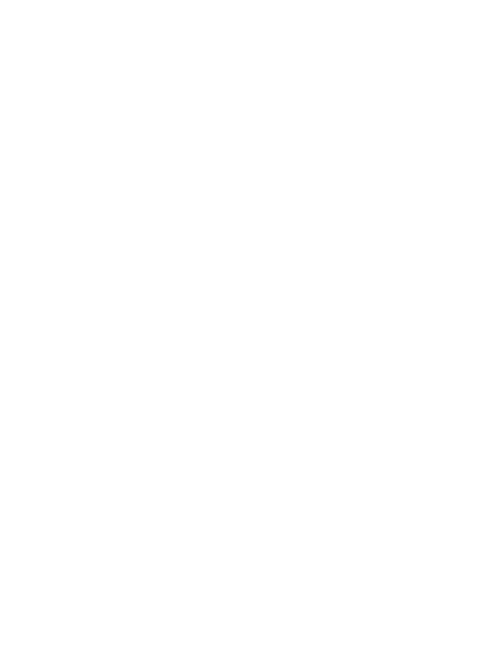

In [4]:
def create_checkerboard_xda(links_xda: xr.DataArray) -> xr.DataArray:
    checkerboard = xr.DataArray(
        data=np.zeros(links_xda.max(dim="point").values, dtype=int), dims=("row", "col")
    )
    # Create an alternating pattern
    # 0 1
    # 1 0
    checkerboard[:, :] = 1
    checkerboard[::2, ::2] = 0
    checkerboard[1::2, 1::2] = 0

    return checkerboard


pixel_width = 60
margin = 40
checkerboard = create_checkerboard_xda(links_xda)

kwargs = dict(
    color={"range": ["#111", "#222"]},
    width=(checkerboard["col"].size + 2) * pixel_width,
    height=(checkerboard["row"].size + 2) * pixel_width,
    margin=margin,
)

yellow = "#ff0"
color = yellow
plotter = ObservablePlotXarrayBuilder(raster_xda=checkerboard, initial_kwargs=kwargs)
plotter.extend(
    [
        create_indicative_dots_layer(
            checkerboard,
            radius=pixel_width // 2,
            opacity=0.3,
            highlight_origin=False,
        ),
        create_polygon_layer(links_df, color=color, stroke_width=4),
    ]
).plot()

### Highlight the _boundary points_


In [5]:
def compute_boundary_points_coords(
    links_df: pd.DataFrame,
    *,
    colorx: str = "#0a0",
    colory: str = "#a0a",
):
    points = []

    for r in links_df.iterrows():
        _, data = r
        dx = data["x2"] - data["x1"]
        dy = data["y2"] - data["y1"]

        if dx != 0:
            arr = np.linspace(1, np.abs(dx), num=np.abs(dx), dtype=int)
            if dx < 0:
                arr = -arr
            for x in (data["x1"] + arr.reshape(-1, 1)).reshape(-1):
                points.append((x, data["y1"], colorx))

        if dy != 0:
            arr = np.linspace(1, np.abs(dy), num=np.abs(dy), dtype=int)
            if dy < 0:
                arr = -arr
            for y in (data["y1"] + arr.reshape(-1, 1)).reshape(-1):
                points.append((data["x1"], y, colory))

    return pd.DataFrame(points, columns=["x", "y", "stroke"])


boundary_points_coords = compute_boundary_points_coords(links_df)
boundary_points_coords[10:20]

,x,y,stroke
10,6,5,#a0a
11,5,5,#0a0
12,4,5,#0a0
13,4,6,#a0a
14,4,7,#a0a
15,5,7,#0a0
16,6,7,#0a0
17,6,8,#a0a
18,6,9,#a0a
19,5,9,#0a0


In the plot below, crossed cells are colored with a different stroke whether they result from a vertical or horizontal move.


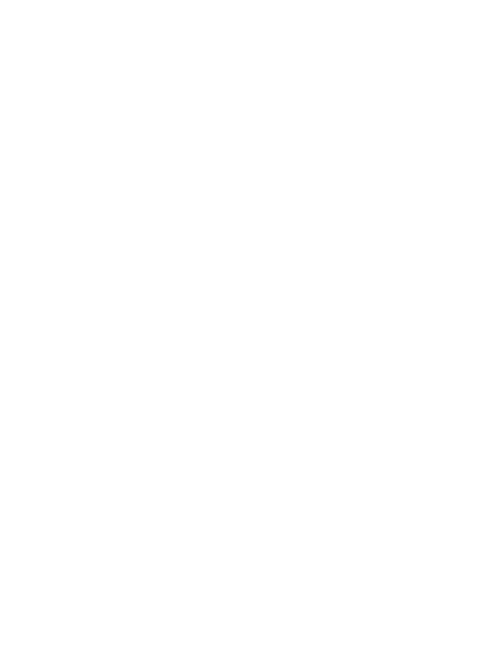

In [6]:
plotter.copy().prepend(
    create_boundary_points_layer(
        boundary_points_coords,
        strokeWidth=4,
        r=pixel_width // 2,
        opacity=1,
        symbol="square",
    )
).plot()

### Highlight the _internal area_ of the polygon


For visualization purposes of the interior points, a flood fill algorithm is used, as in the problem 202310. However, the flood fill algorithm is not required to solve the problem.


In [7]:
def create_contour_xda(
    template_xda: xr.DataArray, *, ymin: int = 0, xmin: int = 0
) -> xr.DataArray:
    contour = template_xda.copy(deep=True)
    contour[:, :] = 0
    for row in boundary_points_coords.iterrows():
        _, data = row
        x, y, _ = data
        contour[y - ymin, x - xmin] = 1
    return contour


contour = create_contour_xda(
    checkerboard.pad(dict(row=(0, 1), col=(0, 1)), constant_values=0)
)
contour.values

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 1, 1]])

In [8]:
from skimage.morphology import flood_fill  # pyright: ignore[reportUnknownVariableType]


filled = contour.copy(data=flood_fill(contour.values, (1, 1), 2))
filled.values

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 2, 2, 2, 2, 2, 1],
       [1, 1, 1, 2, 2, 2, 1],
       [0, 0, 1, 2, 2, 2, 1],
       [0, 0, 1, 2, 2, 2, 1],
       [1, 1, 1, 2, 1, 1, 1],
       [1, 2, 2, 2, 1, 0, 0],
       [1, 1, 2, 2, 1, 1, 1],
       [0, 1, 2, 2, 2, 2, 1],
       [0, 1, 1, 1, 1, 1, 1]])

<xarray.DataArray (row: 10, col: 7)>
array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0]])
Dimensions without coordinates: row, col

<xarray.DataArray (row: 9, col: 6)>
array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1]])
Dimensions without coordinates: row, col

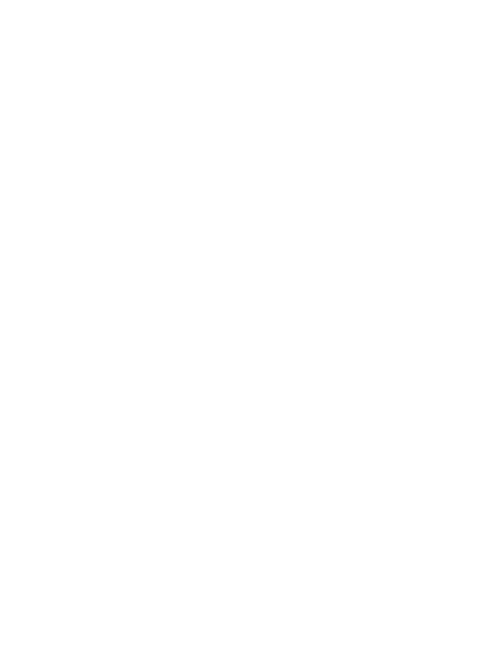

In [9]:
def compute_internal_area_xda(filled_xda: xr.DataArray) -> xr.DataArray:
    interior_area_xda = filled_xda == 2
    display(interior_area_xda * 1)

    # This is a manual morphological operation!
    # It pulls up and left the incomplete internal area from the flood fill algorithm
    extended_area_xda = (
        interior_area_xda
        | interior_area_xda.roll(row=-1, col=-1).values
        | interior_area_xda.roll(col=-1).values
        | interior_area_xda.roll(row=-1).values
    )[:-1, :-1]

    display(extended_area_xda * 1)

    return extended_area_xda


extended_area_xda = compute_internal_area_xda(filled)

plotter.copy(raster_xda=extended_area_xda).plot(
    color={"range": ["#111", "#660"]},
)

In [10]:
filled_df = pd.DataFrame(filled.stack(z=("row", "col")).to_pandas(), columns=["type"])
mapping = {0: "black", 1: "#a00", 2: "#0aa"}
filled_df["stroke"] = filled_df["type"].map(lambda x: mapping[x])
filled_df

type stroke
row col             
0   0       1   #a00
    1       1   #a00
    2       1   #a00
    3       1   #a00
    4       1   #a00
...       ...    ...
9   2       1   #a00
    3       1   #a00
    4       1   #a00
    5       1   #a00
    6       1   #a00

[70 rows x 2 columns]

### Highlight the _interior points_

The solution to the problem is the sum of the _boundary points_ and _interior points_.


In [11]:
filled_df

type stroke
row col             
0   0       1   #a00
    1       1   #a00
    2       1   #a00
    3       1   #a00
    4       1   #a00
...       ...    ...
9   2       1   #a00
    3       1   #a00
    4       1   #a00
    5       1   #a00
    6       1   #a00

[70 rows x 2 columns]

[<function advent_of_code.visualization.observable_plot.create_boundary_points_layer.<locals>.callback() -> list[typing.Any]>,
 <function advent_of_code.visualization.observable_plot.create_indicative_dots_layer.<locals>.callback() -> list[typing.Any]>,
 <function advent_of_code.visualization.observable_plot.create_polygon_layer.<locals>.callback() -> list[typing.Any]>]

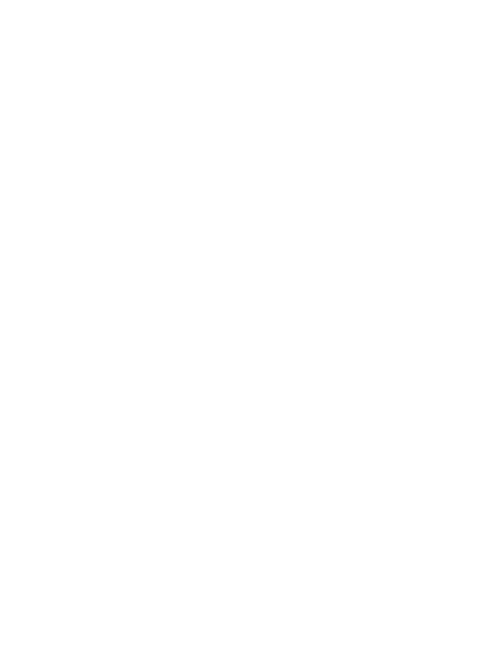

In [12]:
plotter = plotter.copy().prepend(
    # create_boundary_and_interior_points_layer(
    create_boundary_points_layer(
        filled_df,
        x_name="col",
        y_name="row",
        strokeWidth=4,
        r=pixel_width // 2,
        opacity=1,
        symbol="square",
    )
)
display(plotter._marks_producers)
plotter.plot()

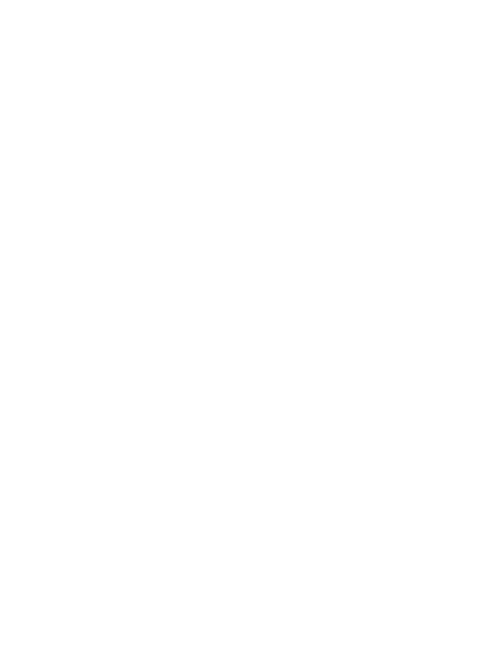

In [13]:
plotter.copy(raster_xda=extended_area_xda).plot(
    color={"range": ["#111", "#660"]},
)

## Mathematical explanation

The _internal area_ of the polygon represented by the yellow arrows can be computed via the shoelace formula. It is the path followed by the miner. It is noted in the following formulas as $A$.

The amount of _boundary points_ is represented by the dark red squares that the red arrows cross. It is the initial space dug by the miner. It is noted in the following formulas as $b$.

The amount of _interior points_ is represented by te dark cyan squares. It is noted bn the following formulas as $b$.

The total area dug by the minor is made of the sum of _boundary points_ and _interior points_ (the red and cyan cells): $area = i + b$.

The area of the polygon can be found using the [shoelace formula](https://en.wikipedia.org/wiki/Shoelace_formula).

$$
A = \frac 1 2 \sum_{i=1}^n (y_i + y_{i+1})(x_i - x_{i+1})
$$

_This formula is used in the `compute_shoelace_formula` function_

However, this is not enough to complete the problem. Indeed, this internal area does not take into account the borders. We want to know the total amount of cells that are dug.

This is where the [Pick's theorem](https://en.wikipedia.org/wiki/Pick%27s_theorem) intervenes:

$$
A = i + \frac{b}{2} - 1
$$

where $A$ is the area of the polygon, $i$ is is the number of points with integer coordinates inside of the polygon, and $b$ is the number of points with integer coordinates on its boundary.

_This formula is used in the `compute_pick_polygon_area_formula` function_

$A$ is known as the polygon's area computed from the shoelace formula. $b$ happens to be equal to the perimeter of the polygon. To compute it, sum all the numbers of meters to dig given in the puzzle input.

The amount of dug cells is given by $i + b$: the interior points and boundary points are both considered to compute it. Then we have:

$$
\begin{aligned}
area
&= i + b \\
&= (A - \frac{b}{2} + 1) + b \\
&= A + \frac{b}{2} + 1 \\
\end{aligned}
$$

Note that the Pick's formula can be used without any change by cleverly choosing the arguments passed to it. Indeed:

$$
\begin{aligned}
Pick(i=A, b=perimeter + 4)
&= i + \frac{b}{2} - 1 \\
&= A + \frac{perimeter + 4}{2} - 1 \\
&= A + \frac{b}{2} + 1 \\
&= area
\end{aligned}
$$

It means the problem can be solved by composing the functions implementing the Pick's formula and the shoelace formula.


## With Actual Input


### Part 1


In [14]:
dig_plan = parse_text_input_part_1(problem.parse_input_text_file())

links_df, links_xda = compute_links_df(dig_plan)
print("Coordinates of the polygon's vertices:")
display(links_xda)
print("Couples of coordinates of the polygon's edges:")
display(links_df)

Coordinates of the polygon's vertices:


<xarray.DataArray (axis: 2, point: 625)>
array([[ 0,  0, -6, ..., 10, 10,  0],
       [ 0,  4,  4, ...,  5,  0,  0]])
Coordinates:
  * axis     (axis) <U1 'y' 'x'
Dimensions without coordinates: point

Couples of coordinates of the polygon's edges:


axis,x1,x2,y1,y2
point,,,,
0,0,4,0,0
1,4,4,0,-6
2,4,12,-6,-6
3,12,12,-6,-9
4,12,15,-9,-9
...,...,...,...,...
619,9,9,9,12
620,9,5,12,12
621,5,5,12,10


In [15]:
def get_extent_from_links(links_df: pd.DataFrame) -> tuple[int, int, int, int]:
    footprint = links_df.describe()[["x1", "y1"]].loc[["min", "max"]].astype(int)
    xmin, xmax = footprint["x1"]
    ymin, ymax = footprint["y1"]
    return xmin, xmax, ymin, ymax


get_extent_from_links(links_df)

(-3, 335, -147, 149)

The small green dot denotes the miner's starting position at (0, 0)


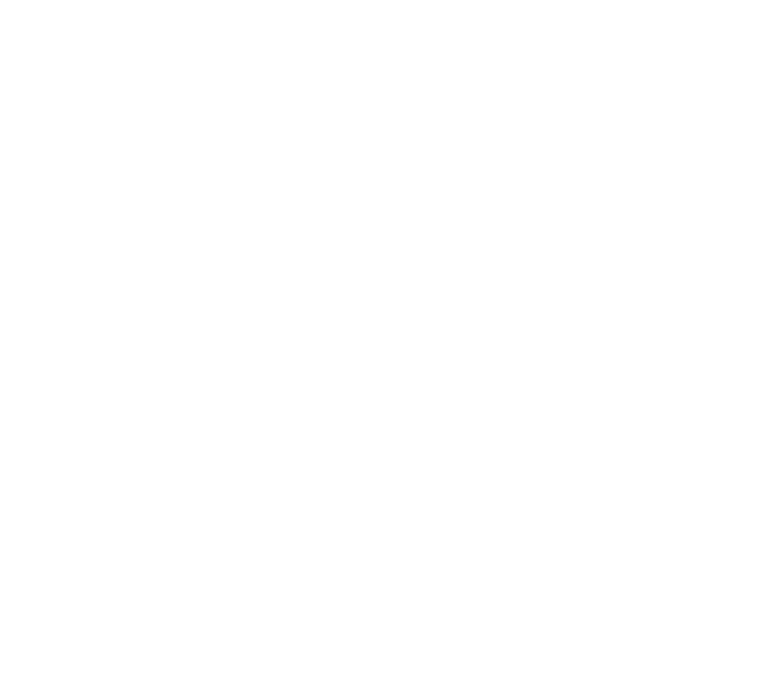

In [16]:
xmin, xmax, ymin, ymax = get_extent_from_links(links_df)
xside = xmax - xmin + 1
yside = ymax - ymin + 1
margin = 40
xticks = xside // 10 if xside > 10 else 10
yticks = yside // 10 if yside > 10 else 10

initial_kwargs = dict(
    width=xside * 2 + 2 * margin,
    aspectRatio=1,
    y=dict(grid=True, reverse=True, ticks=xticks, label="row"),
    x=dict(
        grid=True, reverse=False, ticks=yticks, label="column", axis="both"
    ),  # top bottom
    marginLeft=margin,
    marginRight=margin,
    marginTop=margin,
    marginBottom=margin,
    color={"range": ["#111", "#222"]},
)
plotter = ObservablePlotBuilder(initial_kwargs=initial_kwargs)
plotter.append(lambda: [Plot.frame(dict(stroke="white", opacity=0.6))])
plotter.append(lambda: [Plot.ruleX([0], dict(stroke="white", opacity=0.3))])
plotter.append(lambda: [Plot.ruleY([0], dict(stroke="white", opacity=0.3))])
plotter.append(
    lambda: [
        Plot.dot(  # type:ignore
            [(0, 0)], {"stroke": "#0f0", "r": 4}
        ),
    ]
)
plotter.append(create_polygon_layer(links_df, color="yellow", stroke_width=1))
plotter.plot()

Highlight the _boundary points_


In [17]:
boundary_points_coords = compute_boundary_points_coords(links_df)

plotterbis = plotter.copy()
lastlayer = plotterbis.pop()
plotterbis.append(
    create_boundary_points_layer(
        boundary_points_coords,
        with_discs=False,
        stroke="yellow",
        strokeWidth=1,
        r=1,
        opacity=1,
        symbol="square",
    )
)

ObservablePlotBuilder(_marks_producers=[<function <lambda> at 0x7f4adda3e7a0>, <function <lambda> at 0x7f4addde9ee0>, <function <lambda> at 0x7f4addde9f80>, <function <lambda> at 0x7f4ac857a8e0>, <function create_boundary_points_layer.<locals>.callback at 0x7f4addaa1c60>], _op=<ObsplotJsdomCreator>
theme: 'dark'
debug: False
default: {}
, initial_kwargs={'width': 758, 'aspectRatio': 1, 'y': {'grid': True, 'reverse': True, 'ticks': 33, 'label': 'row'}, 'x': {'grid': True, 'reverse': False, 'ticks': 29, 'label': 'column', 'axis': 'both'}, 'marginLeft': 40, 'marginRight': 40, 'marginTop': 40, 'marginBottom': 40, 'color': {'range': ['#111', '#222']}})

In the plot below, crossed cells are colored with a different stroke whether they result from a vertical or horizontal move.


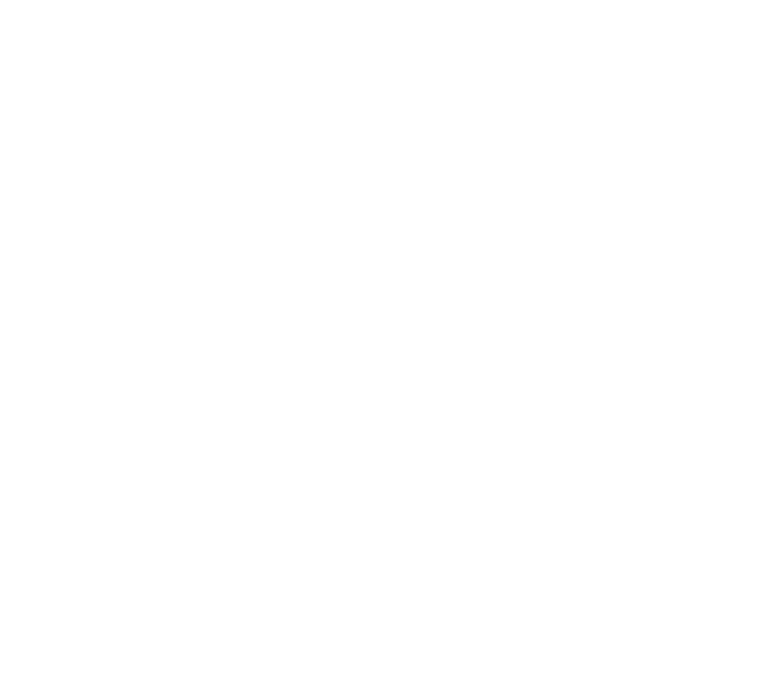

In [18]:
plotterbis = (
    plotter.copy()
    .unstack()
    .append(
        create_boundary_points_layer(
            boundary_points_coords,
            with_discs=False,
            strokeWidth=1,
            r=1,
            opacity=1,
            symbol="square",
        )
    )
)
plotterbis.plot()

Highlight the _internal area_ of the polygon


<xarray.DataArray (row: 297, col: 339)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * row      (row) int64 -147 -146 -145 -144 -143 -142 ... 145 146 147 148 149
  * col      (col) int64 -3 -2 -1 0 1 2 3 4 ... 328 329 330 331 332 333 334 335

<xarray.DataArray (row: 296, col: 338)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * row      (row) int64 -147 -146 -145 -144 -143 -142 ... 144 145 146 147 148
  * col      (col) int64 -3 -2 -1 0 1 2 3 4 ... 327 328 329 330 331 332 333 334

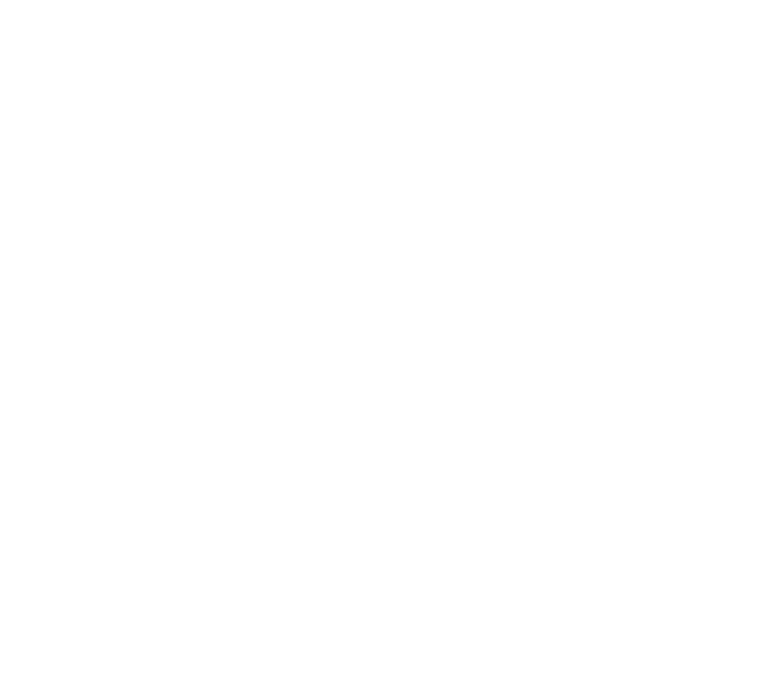

In [19]:
# Create a zero array covering the digging extent
template_xda = xr.DataArray(
    data=np.zeros((yside, xside), dtype=int),
    dims=("row", "col"),
    coords=dict(
        row=np.arange(yside) + ymin,
        col=np.arange(xside) + xmin,
    ),
)

contour = create_contour_xda(template_xda, ymin=ymin, xmin=xmin)
filled = contour.copy(data=flood_fill(contour.values, (150, 150), 2))
internal_area_xda = compute_internal_area_xda(filled)
plotter.copy().prepend(
    lambda: [
        Plot.raster(  # type:ignore
            internal_area_xda.values.reshape(-1).tolist(),
            {
                "width": internal_area_xda["col"].size,
                "height": internal_area_xda["row"].size,
                "x1": xmin,
                "y1": ymin,
                "x2": xmax,
                "y2": ymax,
                "imageRendering": "pixelated",
            },
        ),
    ]
).plot(
    color={"range": ["transparent", "#660"]},
)

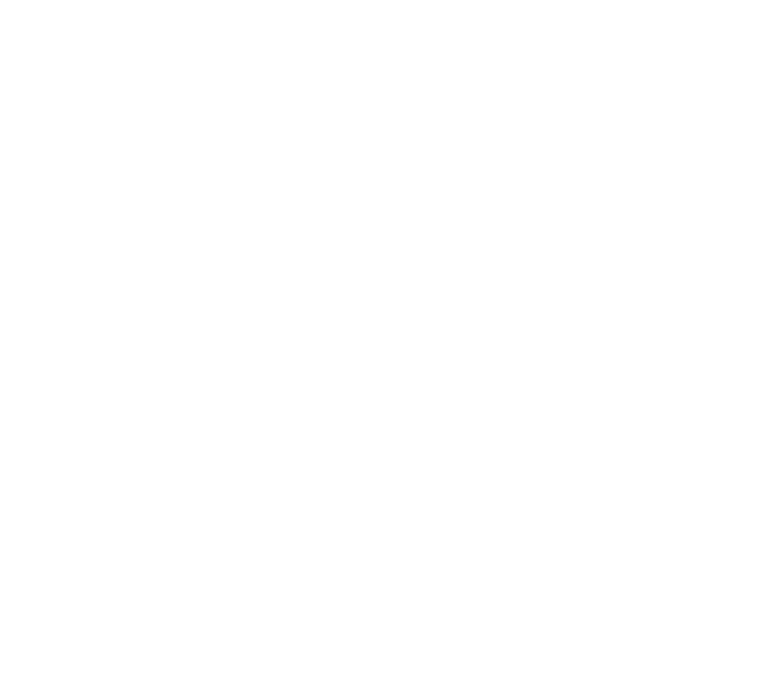

In [20]:
dark_red = "#a00"
dark_cyan = "#0aa"
plotter.copy().unstack().prepend(
    lambda: [
        Plot.raster(  # type:ignore
            filled.values.reshape(-1).tolist(),
            {
                "width": filled["col"].size,
                "height": filled["row"].size,
                "x1": xmin,
                "y1": ymin,
                "x2": xmax,
                "y2": ymax,
                "imageRendering": "pixelated",
            },
        ),
    ]
).plot(
    color={"range": ["transparent", dark_red, dark_cyan]},
)

In [21]:
plotter._marks_producers

[<function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function __main__.<lambda>()>,
 <function advent_of_code.visualization.observable_plot.create_polygon_layer.<locals>.callback() -> list[typing.Any]>]

### Part 2

Only the polygon edges are visualized here. The part 2 is an upscale of the part 1, where using the mathematical formulas is essential to avoid any bruteforce, and to deal with numbers that are multiple order of magnitude larger. 

Indeed, even if the numbers involved are big, the visualization show that at the end, the polygon resulting from the parsing of Part 2 is similar in shape to the one of the Part 1.

However, it seems that overlap between the edges of the polygon is present in the Part 2, unlike in Part 1 where edges never crossed. This seems to be a visual artefact for very small moves in regard to the distances involved (the dynamic range of the moved is increased, with multiple orders of magnitude meeting each other). 

In [22]:
from advent_of_code.y_2023.problem_202318 import parse_text_input_part_2


dig_plan = parse_text_input_part_2(problem.parse_input_text_file())

links_df, links_xda = compute_links_df(dig_plan)
print("Coordinates of the polygon's vertices:")
display(links_xda)
print("Couples of coordinates of the polygon's edges:")
display(links_df)

Coordinates of the polygon's vertices:


<xarray.DataArray (axis: 2, point: 625)>
array([[      0,       0, -498963, ...,  561112,  561112,       0],
       [      0, -379512, -379512, ...,  139147,       0,       0]])
Coordinates:
  * axis     (axis) <U1 'y' 'x'
Dimensions without coordinates: point

Couples of coordinates of the polygon's edges:


axis,x1,x2,y1,y2
point,,,,
0,0,-379512,0,0
1,-379512,-379512,0,-498963
2,-379512,-972791,-498963,-498963
3,-972791,-972791,-498963,-417874
4,-972791,-612523,-417874,-417874
...,...,...,...,...
619,452643,452643,1549341,974279
620,452643,139147,974279,974279
621,139147,139147,974279,561112


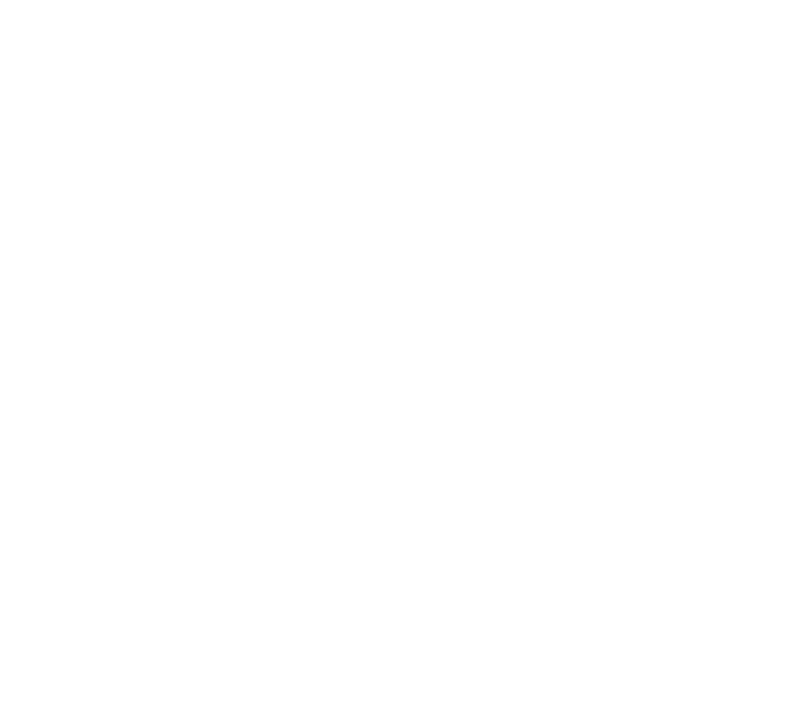

In [23]:
xmin, xmax, ymin, ymax = get_extent_from_links(links_df)
xside = xmax - xmin + 1
yside = ymax - ymin + 1
margin = 40
xticks = 10
yticks = 10

# width = xside * 2 + 2 * margin
width = 800

initial_kwargs = dict(
    width=width,
    aspectRatio=1,
    y=dict(
        grid=True,
        reverse=True,
        ticks=xticks,
        tickFormat=".0s",
        label="row",
    ),
    x=dict(
        grid=True,
        reverse=False,
        ticks=yticks,
        tickFormat=".0s",
        label="column",
        axis="both",
    ),  # top bottom
    margin=60,
    color={"range": ["#111", "#222"]},
)
plotter = ObservablePlotBuilder(initial_kwargs=initial_kwargs)
plotter.append(lambda: [Plot.frame(dict(stroke="white", opacity=0.6))])
plotter.append(lambda: [Plot.ruleX([0], dict(stroke="white", opacity=0.3))])
plotter.append(lambda: [Plot.ruleY([0], dict(stroke="white", opacity=0.3))])
plotter.append(
    lambda: [
        Plot.dot(  # type:ignore
            [(0, 0)], {"stroke": "#0f0", "r": 4}
        ),
    ]
)
plotter.append(create_polygon_layer(links_df, color="yellow", stroke_width=1))
plotter.plot()